<a href="https://colab.research.google.com/github/Marwan-Aj/PMASD/blob/main/IDs_to_ASD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import ...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import re
from pickle import load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_theme()

from scipy.io import wavfile
import librosa

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

from keras import Model
from keras.optimizers import Adam
from keras.models import Sequential 
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, ReLU
from keras.utils import to_categorical



## Some parameters + Load dataframes

In [ ]:
PATH = 'drive/MyDrive/PMSAD/'

train, test = {}, {}
machines = ['ToyCar', 'ToyConveyor', 'fan', 'pump', 'slider', 'valve']
for machine in machines : 
  train[machine] = PATH+machine+'/train/*.wav'
  test[machine] = PATH+machine+'/test/*.wav'

params = {'fe':16000,
          'n_fft': 1024,
          'n_mels': 128,
          'frames': 5,
          'hop_length': 512,
          'lower_edge_hertz': 0,
          'upper_edge_hertz': 8000}


logmel_shape = (320, 128, 1)
id_shape=(23)
machine_shape=(6)
asd_shape=(2)
unkPb = 'Problem value must be \'machine\' or \'id\' or \'asd\''     # Message d'erreur



## Dict avec les correspondances ids actuels vers ids dans {0...22}
ids = {}
ids['ToyCar'] = {'04':'03',
                 '03':'02',
                 '02':'01',
                 '01':'00'}
ids['ToyConveyor'] = {'03':'06',
                      '02':'05',
                      '01':'04'}
ids['fan'] = {'06':'10',
              '04':'09',
              '02':'08',
              '00':'07'}
ids['pump'] = {'06':'14',
               '04':'13',
               '02':'12',
               '00':'11'}
ids['slider'] = {'06':'18',
                 '04':'17',
                 '02':'16',
                 '00':'15'}
ids['valve'] = {'06':'22',
                '04':'21',
                '02':'20',
                '00':'19'}


## Charger un df avec les chemins des fichiers audio et leurs classes
## Argument : le chemin vers les données train ou test d'une machine
## Colonnes df : filepath(str), machine(str), id(str, entre '00' et '22'), asd(int, 0 ou 1)
def load_df(path) :
  liste = glob.glob(path)
  df = pd.DataFrame(liste, columns=['filepath'])
  df['machine'] = df['filepath'].apply(lambda x: re.findall(r"(ToyCar|ToyConveyor|fan|pump|slider|valve)", x)[0])
  df['id'] = df['filepath'].apply(lambda x: re.findall(r"[0-9]{2}", x)[0])
  df['id'].replace(ids[df['machine'].unique()[0]], inplace=True)
  df['asd'] = df['filepath'].apply(lambda x: str(re.findall(r"(normal|anomaly)", x)[0])).replace({'normal':1, 'anomaly':0})
  return df


## Charger 2 dfs (train et test) avec l'ensemble des chemins des fichiers audio et leurs classes
## Colonnes df : filepath(str), machine(str), id(str, entre '00' et '22'), asd(int, 0 ou 1)
def load_fulldf() : 
  machine_dfs = []
  for path in train.values() :
    machine_dfs.append(load_df(path))
  df_train = pd.concat(machine_dfs, ignore_index=True)
  machine_dfs = []
  for path in test.values() :
    machine_dfs.append(load_df(path))
  df_test = pd.concat(machine_dfs, ignore_index=True)
  return df_train, df_test


In [ ]:
df_train, df_test = load_fulldf()

## Load train audio & target data functions

In [ ]:
def load_audio(filepath):
    data, fe = librosa.load(filepath, sr=16000)
    return data, fe
    

def logMelSpectrogram(audio, params):

    stfts = librosa.stft(audio,
                         n_fft = params['n_fft'],
                         hop_length = params["hop_length"],
                         ).T

    power_spectrograms = np.real(stfts * np.conj(stfts))

    num_spectrogram_bins = power_spectrograms.shape[-1]

    linear_to_mel_weight_matrix = librosa.filters.mel(sr=params['fe'],
                                                      n_fft=params['n_fft']+1,
                                                      n_mels=params['n_mels'],
                                                      fmin=params['lower_edge_hertz'],
                                                      fmax=params['upper_edge_hertz']
                                                      ).T

    mel_spectrograms = np.tensordot(power_spectrograms,
                                    linear_to_mel_weight_matrix,
                                    1)

    return (np.log(mel_spectrograms + 1e-6).astype(np.float32))


## Pour charger, dans un narray, les données audio du df en argument
def load_data(df, T_max=10.21):
  X_audio = []
  for i, a_path in enumerate(df.filepath) :
    data, fe = load_audio(a_path)
    if len(data)>= T_max*fe:
      data = data[:int(T_max*fe)]
    else :
      data = np.concatenate([data, np.zeros(int(T_max*fe - len(data)))])
    spectre_audio = logMelSpectrogram(data, params)
    X_audio.append(spectre_audio)
    if int(i%(df.shape[0]*0.1))==0 : print(i,'on',df.shape[0],'files') 
  print("Done !")
  return np.array(X_audio)


## Pour charger les données target train et test, selon la valeur de problem
def load_target(df_train, df_test, problem) : 
  if problem == 'machine' : 
    ytrain, ytest = df_train.machine, df_test.machine
  elif problem == 'id' : 
    ytrain, ytest = df_train.id, df_test.id
  elif problem == 'asd' : 
    #df_train[df_train.machine!=machineRef].asd = 0
    #df_train[(df_train.machine==machineRef) & (df_train.id!=idRef)].asd = 0
    ytrain, ytest = df_train.asd, df_test.asd
  else : raise ValueError(unkPb)
  return ytrain, ytest

## Model using Conv2D for IDs classification

In [ ]:
def relu_bn(inputs) :
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn


def create_model(yshape, Xshape=logmel_shape):

  inputs = Input(shape=Xshape)

  x = Conv2D(32, (5, 5), strides=(2,1), padding='same')(inputs)
  x = relu_bn(x)
  x = Conv2D(64, (5, 5), strides=(2,1), padding='same')(x)
  x = relu_bn(x)
  x = Conv2D(128, (3, 3), strides=(1,1), padding='same')(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Conv2D(256, (3, 3), strides=(1,1), padding='same')(x)
  x = relu_bn(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Conv2D(512, (3, 3), strides=(1,1), padding='same')(x)
  x = relu_bn(x)
  x = MaxPooling2D(pool_size=2)(x)

  x = Flatten()(x)

  x = Dense(units = 512)(x)
  x = relu_bn(x)
  x = Dropout(0.2)(x)
  x = Dense(units = 512)(x)
  x = relu_bn(x)
  x = Dropout(0.2)(x)
  x = Dense(units = 1024)(x)
  x = relu_bn(x)
  x = Dropout(0.2)(x)
  x = Dense(units = 1024)(x)
  x = relu_bn(x)

  outputs = Dense(units=yshape, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

  return model

## Load + transform test data

In [ ]:
## Charger l'ensemble des données logmel de test
Xtest_full = load_data(df_test)

0 on 10868 files
1087 on 10868 files
2174 on 10868 files
3261 on 10868 files
4348 on 10868 files
5434 on 10868 files
6521 on 10868 files
7608 on 10868 files
8695 on 10868 files
9782 on 10868 files
Done !


In [ ]:
X_test = Xtest_full.reshape([-1, Xtest_full.shape[1] * Xtest_full.shape[2]])
scaler = load(open(PATH+'scaler.pkl', 'rb'))      # récupère le data scaler pour transformer X_test
X_test = scaler.transform(X_test)
X_test = X_test.reshape([-1, Xtest_full.shape[1], Xtest_full.shape[2], 1])

## IDs Prediction

In [ ]:
model = create_model(yshape=id_shape)
model.load_weights(PATH+'checkpoint')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

## Testing IDs classification

In [ ]:
_, ytest_full = load_target(df_train, df_test, problem='id')
ytest_full = to_categorical(ytest_full)
y_test = np.argmax(ytest_full, axis=-1)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.95      0.66       614
           1       0.97      0.85      0.91       615
           2       0.93      0.64      0.76       615
           3       0.97      0.56      0.71       615
           4       1.00      0.95      0.98      1200
           5       0.96      1.00      0.98      1155
           6       1.00      1.00      1.00      1154
           7       0.72      0.94      0.82       507
           8       0.94      0.73      0.82       459
           9       0.89      0.85      0.87       448
          10       0.99      0.45      0.62       461
          11       0.65      0.78      0.71       243
          12       0.90      0.95      0.93       211
          13       0.98      0.55      0.70       200
          14       0.37      0.60      0.46       202
          15       0.29      0.25      0.27       456
          16       0.32      0.49      0.39       367
          17       1.00    

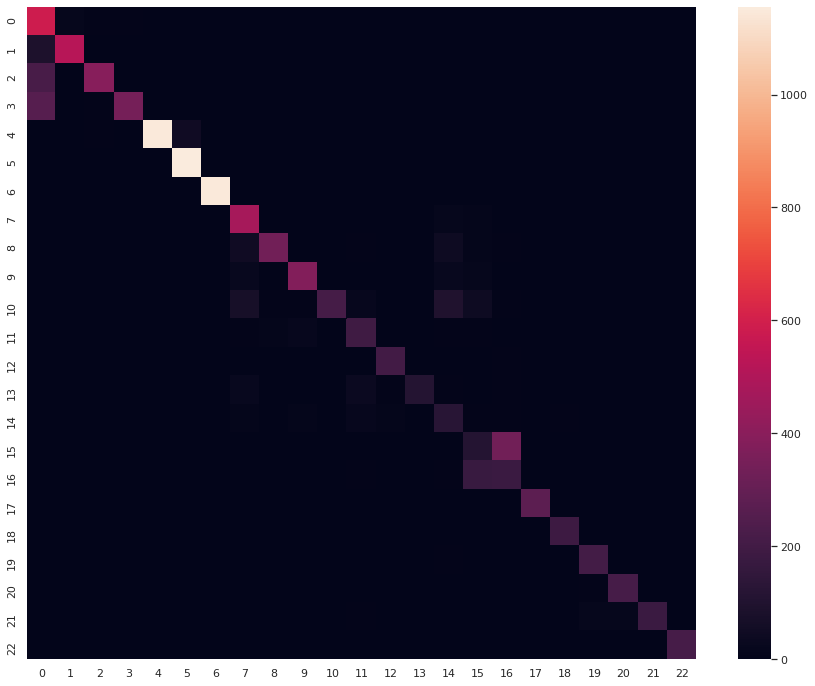

In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred)
plt.figure(figsize=(15,12))
ax = sns.heatmap(confusion_matrix)
ax.set(xlabel=None)
ax.set(ylabel=None);



## Testing on ASD data

In [ ]:
_, ytest_full = load_target(df_train, df_test, problem='asd')

In [ ]:
for machine in machines :
  
  machineRef = machine
  ls = list(ids[machineRef].values())

  y_pred_machineToAsd = []

  for id in y_pred : 
    if id in map(lambda x : int(x), ls) :
      y_pred_machineToAsd.append(1)
    else : 
      y_pred_machineToAsd.append(0)
  y_pred_machineToAsd = np.array(y_pred_machineToAsd)

  print(machineRef.upper(),':\n')
  print(classification_report(ytest_full, y_pred_machineToAsd))
  print(pd.crosstab(ytest_full, y_pred_machineToAsd))
  fpr, tpr, _ = roc_curve(ytest_full, y_pred_machineToAsd, pos_label=1)
  print('\nAUC =',round(auc(fpr, tpr),3))
  print('\n\n')

TOYCAR :

              precision    recall  f1-score   support

           0       0.52      0.80      0.63      5469
           1       0.57      0.26      0.36      5399

    accuracy                           0.53     10868
   macro avg       0.55      0.53      0.50     10868
weighted avg       0.55      0.53      0.50     10868

col_0     0     1
asd              
0      4401  1068
1      3999  1400

AUC = 0.532



TOYCONVEYOR :

              precision    recall  f1-score   support

           0       0.59      0.80      0.68      5469
           1       0.69      0.44      0.54      5399

    accuracy                           0.62     10868
   macro avg       0.64      0.62      0.61     10868
weighted avg       0.64      0.62      0.61     10868

col_0     0     1
asd              
0      4366  1103
1      3000  2399

AUC = 0.621



FAN :

              precision    recall  f1-score   support

           0       0.46      0.77      0.57      5469
           1       0.24      

In [ ]:
for i in np.arange(23) :
  
  idRef = i
  y_pred_idToAsd = []

  for id in y_pred : 
    if id == int(idRef) : 
      y_pred_idToAsd.append(1)
    else : 
      y_pred_idToAsd.append(0)
  y_pred_idToAsd = np.array(y_pred_idToAsd)

  print('ID', idRef,':\n')
  print(classification_report(ytest_full, y_pred_idToAsd))
  print(pd.crosstab(ytest_full, y_pred_idToAsd))
  fpr, tpr, _ = roc_curve(ytest_full, y_pred_machineToAsd, pos_label=1)
  print('\nAUC =',round(auc(fpr, tpr),3))
  print('\n\n')

ID 0 :

              precision    recall  f1-score   support

           0       0.48      0.85      0.61      5469
           1       0.30      0.06      0.11      5399

    accuracy                           0.46     10868
   macro avg       0.39      0.46      0.36     10868
weighted avg       0.39      0.46      0.36     10868

col_0     0    1
asd             
0      4669  800
1      5050  349

AUC = 0.495



ID 1 :

              precision    recall  f1-score   support

           0       0.51      0.97      0.67      5469
           1       0.65      0.06      0.12      5399

    accuracy                           0.52     10868
   macro avg       0.58      0.52      0.39     10868
weighted avg       0.58      0.52      0.40     10868

col_0     0    1
asd             
0      5283  186
1      5049  350

AUC = 0.495



ID 2 :

              precision    recall  f1-score   support

           0       0.52      0.99      0.68      5469
           1       0.83      0.07      0.12  